# ***Assignment 1.2 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

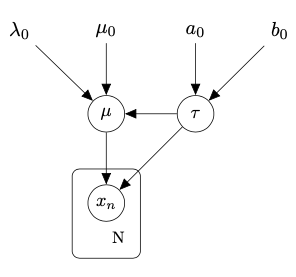

### ***Question 1.2.7:***

Implement a function that generates data points for the given model.

In [145]:
import numpy as np
import matplotlib.pyplot as plt
def generate_data(mu, tau, size):
    variance = 1 / tau
    return np.random.normal(mu, np.sqrt(variance), size)


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



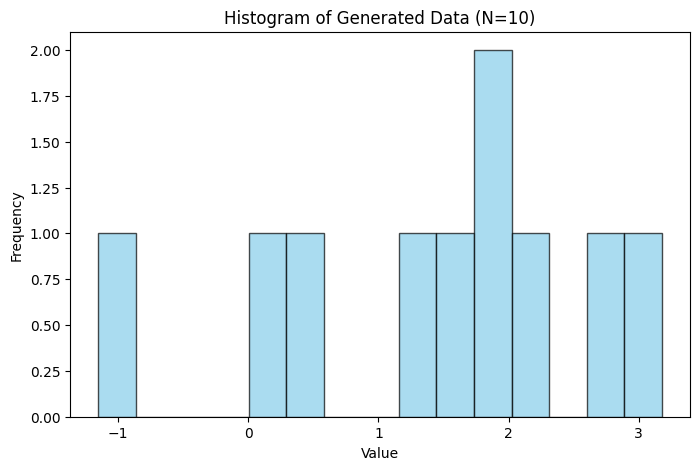

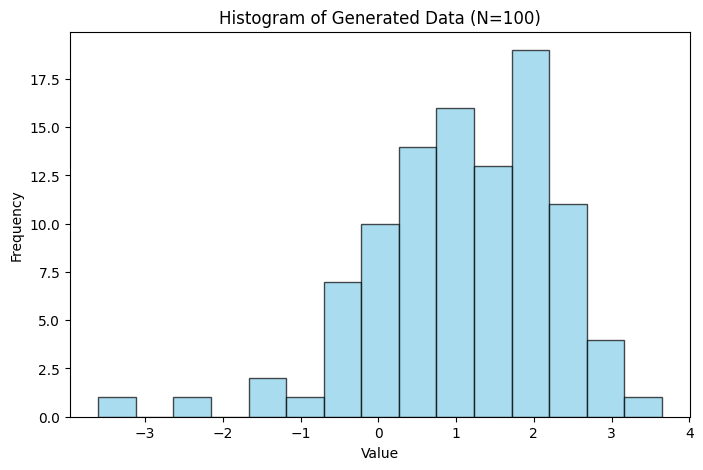

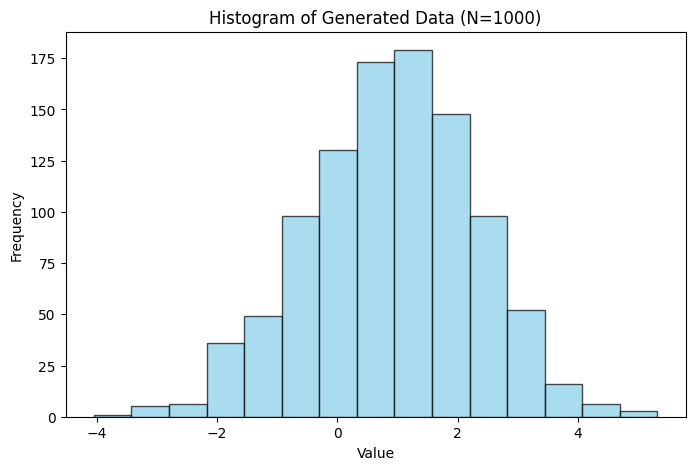

In [146]:
mu = 1
tau = 0.5
sizes = [10, 100, 1000]

datasets = {size: generate_data(mu, tau, size) for size in sizes}

# Visulaize the datasets via histograms
for size, data in datasets.items():
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=15, color='skyblue', alpha=0.7, edgecolor='black')
    plt.title(f"Histogram of Generated Data (N={size})")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()


### ***Question 1.2.8:***

Find ML estimates of the variables μ and τ

In [147]:
def ML_est(data):
  mu_ml = np.mean(data)
  tau_ml = 1 / np.var(data)
  return mu_ml, tau_ml

ml_estimates = {size: ML_est(data) for size, data in datasets.items()}

import pandas as pd
ml_results = pd.DataFrame.from_dict(
    ml_estimates, orient='index', columns=['ML Estimate of μ', 'ML Estimate of τ']
)

print(ml_results)

      ML Estimate of μ  ML Estimate of τ
10            1.404882          0.652935
100           1.080868          0.737661
1000          0.900959          0.524248


### ***Question 1.2.9:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [148]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
  N = len(D)
  x_mean = np.mean(D)
  a_N = a_0 + N / 2
  b_N = b_0 + 0.5 * np.sum((D - x_mean)**2) + (lambda_0 * N / (2 * (lambda_0 + N))) * (mu_0 - x_mean)**2
  mu_N = (lambda_0 * mu_0 + N * x_mean) / (lambda_0 + N)
  lambda_N = lambda_0 + N

  return {"a_N": a_N, "b_N": b_N, "mu_N": mu_N, "lambda_N": lambda_N}

### ***Question 1.2.10:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [149]:
# prior parameters
mu_0 = 0
lambda_0 = 1
a_0 = 1
b_0 = 1

Continue with a helper function that computes ELBO:


In [150]:
from scipy.stats import gamma, norm
def compute_elbo (D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N):
  
  gaussian_prior_kl = norm.logpdf(mu_N, loc=mu_0, scale=np.sqrt(1 / lambda_0))
  
  gamma_prior_kl = gamma.logpdf(a_N, a=a_0, scale=1/b_0) - gamma.logpdf(a_N, a=a_N, scale=1/b_N)
  
  data_likelihood = np.sum(norm.logpdf(D, loc=mu_N, scale=np.sqrt(1 / lambda_N)))
  
  elbo = gaussian_prior_kl + gamma_prior_kl + data_likelihood

  return elbo


Now, implement the CAVI algorithm:

In [151]:
def CAVI(D, a_0, b_0, mu_0, lambda_0):
  N = len(D)
  x_mean = np.mean(D)
  x_var = np.var(D)
  
  # Initialize variational parameters
  a_N = a_0 + N / 2  
  b_N = b_0 + 0.5 * np.sum((D - x_mean)**2) 
  mu_N = mu_0 
  lambda_N = lambda_0 
  
  elbos = []
  
  for _ in range(1000):
      # Update variational parameter b_N (tau rate)
      b_N_new = b_0 + 0.5 * np.sum((D - mu_N)**2) + (lambda_N * (mu_0 - mu_N)**2)
      
      # Update variational parameter lambda_N (precision for mu)
      lambda_N_new = lambda_0 + N * a_N / b_N_new
      
      # Update variational parameter mu_N (mean for mu)
      mu_N_new = (lambda_0 * mu_0 + N * x_mean * a_N / b_N_new) / lambda_N_new
      
      # Compute ELBO
      elbo = compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N_new, mu_N_new, lambda_N_new)
      elbos.append(elbo)
      
      # Check for convergence
      if np.abs(mu_N_new - mu_N) < 1e-6 and np.abs(b_N_new - b_N) < 1e-6:
          break
      
      # Update parameters for next iteration
      b_N, lambda_N, mu_N = b_N_new, lambda_N_new, mu_N_new
  
  return {"a_N": a_N, "b_N": b_N, "mu_N": mu_N, "lambda_N": lambda_N, "elbos": elbos}

Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.


CAVI Results: {'a_N': 501.0, 'b_N': np.float64(1273.3206467065222), 'mu_N': np.float64(0.8986744830589923), 'lambda_N': np.float64(394.4594175440804), 'elbos': [np.float64(326946.9647904092), np.float64(242821.11570719618), np.float64(263352.7766085712), np.float64(258169.518286818), np.float64(259467.44008717954), np.float64(259141.76132446836), np.float64(259223.4395669424), np.float64(259202.95251160138), np.float64(259208.0910380977), np.float64(259206.8021915998), np.float64(259207.12545973976), np.float64(259207.0443776683), np.float64(259207.06471465982), np.float64(259207.0596137388), np.float64(259207.06089315098), np.float64(259207.06057224923)]}


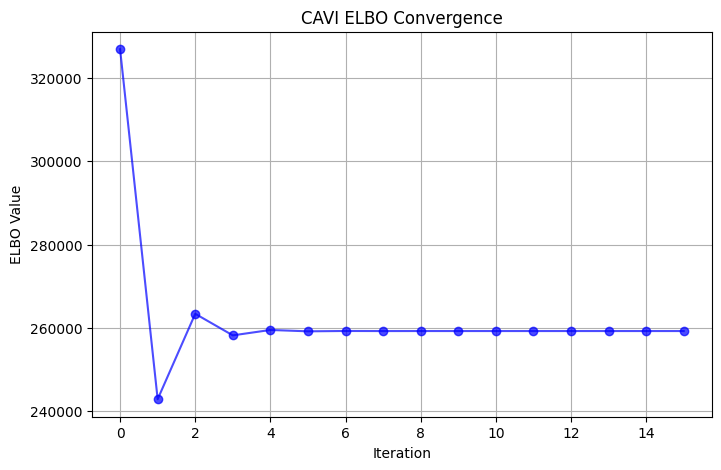

0.9000584580818433
0.8986744830589923
0.9009585165399251


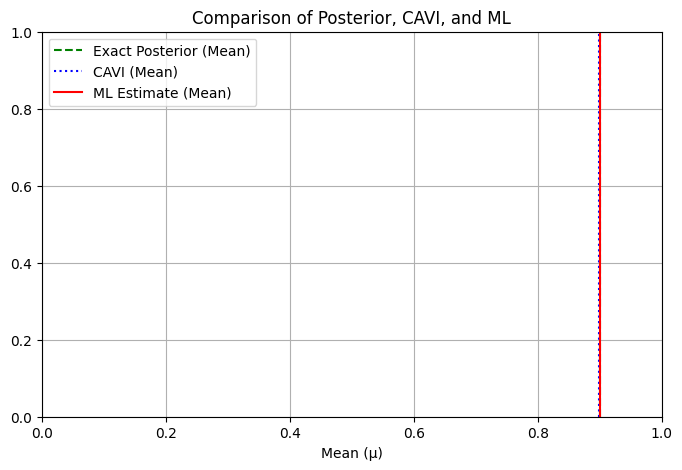

In [ ]:
cavi_results = CAVI(data, a_0, b_0, mu_0, lambda_0)

# Display results
print("CAVI Results:", cavi_results)

# Compare ELBO convergence
plt.figure(figsize=(8, 5))
plt.plot(cavi_results["elbos"], marker='o', linestyle='-', color='b', alpha=0.7)
plt.title("CAVI ELBO Convergence")
plt.xlabel("Iteration")
plt.ylabel("ELBO Value")
plt.grid()
plt.show()

# Visualize comparison of exact posterior, CAVI, and ML estimates
posterior_params = compute_exact_posterior(data, a_0, b_0, mu_0, lambda_0)
ml_estimates = ML_est(data)

plt.figure(figsize=(8, 5))
# Exact posterior mean and precision
plt.axvline(posterior_params["mu_N"], color="g", linestyle="--", label="Exact Posterior (Mean)")
print(posterior_params["mu_N"])
# CAVI mean
plt.axvline(cavi_results["mu_N"], color="b", linestyle=":", label="CAVI (Mean)")
print(cavi_results["mu_N"])
# ML estimate
plt.axvline(ml_estimates[0], color="r", linestyle="-", label="ML Estimate (Mean)")
print(ml_estimates[0])
plt.title("Comparison of Posterior, CAVI, and ML")
plt.xlabel("Mean (μ)")
plt.legend()
plt.grid()
plt.show()
